Finaly, lets use the data to build and test our model. First, we import the relevant packages.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import json
import pandas as pd
from random import sample, seed
from IPython.display import Image, display
import numpy as np
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from google.colab import files
%matplotlib inline
sns.set_style("darkgrid")

Import the `pokemon.csv` and `images.zip` files from the data cleaning, then unzip the images file, and make the pokemon file a dataframe.

If the model was already changed, we can import the model as `model.h5` and the history as `history`.

In [ ]:
files.upload()

In [ ]:
! unzip images.zip

pokemon = pd.read_csv("pokemon_data.csv")
pokemon.fillna("none")

Next we make the folders to hold our train-test split

In [ ]:
# Delete all directories if required
! rm -r train
! rm -r test

In [12]:
# make all directories (if required)
! mkdir train
! mkdir test
! mkdir train/poison
! mkdir train/none
! mkdir train/flying
! mkdir train/dark
! mkdir train/electric
! mkdir train/ice
! mkdir train/ground
! mkdir train/fairy
! mkdir train/grass
! mkdir train/fighting
! mkdir train/psychic
! mkdir train/steel
! mkdir train/fire
! mkdir train/rock
! mkdir train/water
! mkdir train/dragon
! mkdir train/ghost
! mkdir train/bug
! mkdir train/normal
! mkdir test/poison
! mkdir test/none
! mkdir test/flying
! mkdir test/dark
! mkdir test/electric
! mkdir test/ice
! mkdir test/ground
! mkdir test/fairy
! mkdir test/grass
! mkdir test/fighting
! mkdir test/psychic
! mkdir test/steel
! mkdir test/fire
! mkdir test/rock
! mkdir test/water
! mkdir test/dragon
! mkdir test/ghost
! mkdir test/bug
! mkdir test/normal

Next, we'll setup our model in a class called a Pokemodel. The class will have a number of parameters set to default like a seed, the image path, the number of images, the sidelength of each image (256 units) and the number of classes (19, one for every type and none).

The remaining parameters are the splting fraction (the size of the training set relative to the total number of images), the batch size, the number of epochs and the learning_rate.

In [13]:
class Pokemodel:
  def __init__(self, split_frac, batch_size, epochs, learn_rate, seed_number = 50, 
               image_path = "/content/content/images", images = 721, image_length = 256, classes = 19):
    self.split_frac = split_frac
    self.batch_size = batch_size
    self.epochs = epochs
    self.learn_rate = learn_rate
    self.seed_number = seed_number
    self.image_path = image_path
    self.images = images
    self.image_length = image_length
    self.classes = classes 
    # Attributes of the model to be defined later:
    self.train, self.test, self.model, self.history = None, None, None, None


  def get_type1_from_image(self,filename):
    # given an image, this exctracts type1 from the pokemon dataset for that image
    index = int(filename.split(".")[0]) - 1
    return pokemon.type1[index]

  def get_name_from_image(self,filename):
    # given an image, this exctracts the name from the pokemon dataset for that image
    index = int(filename.split(".")[0]) - 1
    return pokemon.name[index]


  def splitter(self, number):
    # This randomly splits all pokedex numbers into training and testing numbers
    seed(self.seed_number)
    sample_size = int(self.split_frac*self.images)
    s = sample(range(self.images - 1), sample_size)
    if number in s:
      return "train"
    else:
      return "test" 

  def split(self):
    #preforms the train test split
    for filename in os.listdir(self.image_path):
      if not filename == ".ipynb_checkpoints": #This file was causing some problems
        index = int(filename.split(".")[0])-1
        type_str = self.get_type1_from_image(filename)
        split_str = self.splitter(index)
        destination_path = "/content/" + split_str + "/" + type_str + "/" + filename
        shutil.copy(self.image_path + "/" + filename, destination_path)

  def process(self, path):
    #image preprocessing for training and testing data. Since the dataset is small, we use some of the transformation parameters
    #this function also then creates the data for the model to use
    datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

    data = datagen.flow_from_directory(
            path, target_size=(self.image_length, self.image_length),
    batch_size=self.batch_size,
    class_mode='categorical',
    shuffle=True
    )

    return data

  def get_data(self):
    # gets the data ready for the model
    self.train = self.process("/content/train")
    self.test = self.process("/content/test")
  

  def create_model(self):
    # makes the model, and compiles it
    # model parameters:
    conv_L1, conv_L2, conv_L3 = 32, 64, 128
    act_1 = "relu"
    metric = "accuracy"

    # the model has 3 covolutional layers, and one dense layer before the ouptut

    self.model = tf.keras.models.Sequential(
        [tf.keras.layers.Conv2D((conv_L1), (3,3), activation=act_1, 
          input_shape=(self.image_length, self.image_length, 3)),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(conv_L2, (3,3), activation=act_1),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(conv_L3, (3,3), activation=act_1),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(conv_L3, activation=act_1),
         tf.keras.layers.Dense(self.classes, activation='softmax')])

    self.model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = self.learn_rate),   
              metrics=[metric])

  def train_model(self):
    # trains the model
    self.history = self.model.fit(self.train,
                              steps_per_epoch=self.train.samples // self.batch_size,
                              validation_data = self.test,
                              epochs=self.epochs)
    
  def decode_prediction(self, prediction):
    # The output is a length 19 float array, (almost boolean) this function converts that array to a type
    labels = ["bug", "dark", "dragon", "electric", "fairy", "fighting", "fire",
              "flying", "ghost", "grass", "ground", "ice", "none", "normal",
              "poison", "psychic", "rock", "steel", "water"]

    return labels[np.argmax(prediction)]

  def predict_from_number(self,pokedex,verbose = 0):
    # makes a prediction for a specific pokedex number
    filename =  str(pokedex) + ".png"
    filepath = self.image_path + "/" + filename
    type1 = self.get_type1_from_image(filename)
    name = self.get_name_from_image(filename)

    # preps the file for a prediction
    img = load_img(filepath, target_size=(self.image_length,self.image_length))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # prediction and decoding
    prediction = self.model.predict(images, verbose = 0)
    type1_hat = self.decode_prediction(prediction)

    # output either the type, or else a full breakdown
    if verbose == 0: return type1_hat
    else:
      print(f"#{pokedex}; {name}. ({self.splitter(pokedex)})",
      f"\nType1 (actual): {type1}",
      f"\nType1 (prediction): {type1_hat}")
      display(Image(filepath))


  def predict_from_images(self):
    # makes a prediction from uploaded images
    uploaded = files.upload()

    for filepath in uploaded.keys():
      # for every uploaded file, prep for prediction
      img = load_img(filepath, target_size=(self.image_length,self.image_length))
      x = img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])

      # make and decode the prediction
      prediction = self.model.predict(images)
      type1_hat = self.decode_prediction(prediction)

      # output the prediction and image
      print(f"Type1 (prediction): {type1_hat}")
      display(Image(filepath))

  def plot_acc(self):
    # plots the accuracy vs. epoch data to see improvement
    colors = plt.cm.rainbow(np.linspace(0, 2, self.classes))
    acc = self.history.history['accuracy']
    val_acc = self.history.history['val_accuracy']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, color = colors[0], label='Training accuracy')
    plt.plot(epochs, val_acc, color = colors[1], label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

  def save(self, model_name, history_name):
    if not self.model == None:
      self.model.save(model_name + ".h5")
    if not self.history == None:
      with open(history_name, 'w') as f:
        json.dump(self.history.history, f)

  def load(self, model_name, history_name):
    if not model_name == None:
      self.model = tf.keras.models.load_model(model_name)
    if not history_name == None:
      with open(history_name, 'r') as f:
          history_dict = json.load(f)
          history_obj = tf.keras.callbacks.History()
          history_obj.history = history_dict
          self.history = history_obj

# Hyperparameters:

split_frac = 0.9
batch_size = 30
epochs = 50
learn_rate = 2e-4

pokemodel = Pokemodel(split_frac, batch_size, epochs, learn_rate)

Splitting, and preprocessing the data, then creating and training a model is now as simple as follows:

In [ ]:
pokemodel.split()
pokemodel.get_data()
pokemodel.create_model()
pokemodel.train_model()

Then we can save and download the model and history (incase we want to use it later but not retrain)

In [ ]:
pokemodel.save("model", "history")
files.download("model.h5")
files.download("history")

If we have trained the model once, and relaunched the page we can load the file we just downloaded. If necessary we can upload it at the top with the files.upload().

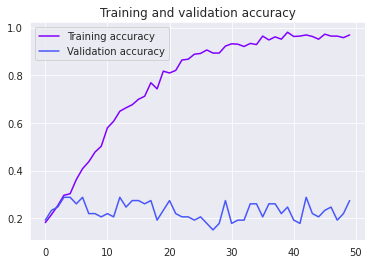

<Figure size 432x288 with 0 Axes>

In [16]:
pokemodel = Pokemodel(split_frac, batch_size, epochs, learn_rate)
pokemodel.load("model.h5", "history")
pokemodel.plot_acc()

Our final model has near perfect training accuracy and about 25% testing accuracy. This is obviously an example of overfitting. That's because our sample size of 721 total images is **very** small. 

We platteaud somewehre around 35-40 epochs so on a second pass we could cut down on the number of epochs speeding up the model, and maybe play with some of the models parameters to improve accuracy.

If I had the resources, I would source a multiplicity of images for every pokemon, this would massively increase the datasize. We tried to mimic this by using the arguments in the `ImageDataGenerator` function from `keras`.

Alternatively, we could classify by generation, and not type (as there are 6 generations vs 19 types) so classification accuracy would improve.

Lastly, its worth noting that 25% is not that bad. If we assumed that there the model just guessed at random (with a uniform distribution over types) then we would expect $1/19 \approx 5%$ testing accuracy. So our model is 5 times better than no model at all.

Finally, lets take a look at what the incorrect testing images look like, to see what the model is trying to do:

#56; Mankey. (test) 
Type1 (actual): fighting 
Type1 (prediction): rock


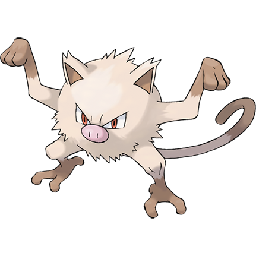

#67; Machoke. (test) 
Type1 (actual): fighting 
Type1 (prediction): bug


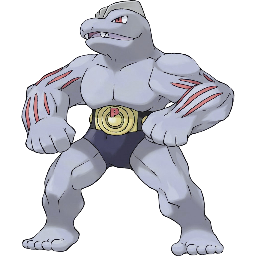

#165; Ledyba. (test) 
Type1 (actual): bug 
Type1 (prediction): ground


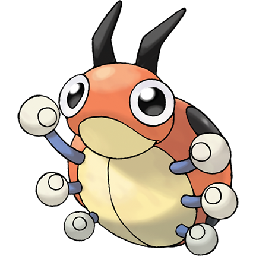

#240; Magby. (test) 
Type1 (actual): fire 
Type1 (prediction): normal


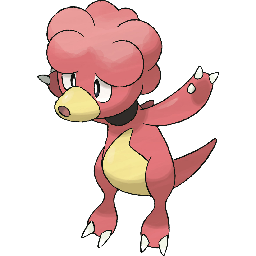

#363; Spheal. (test) 
Type1 (actual): ice 
Type1 (prediction): ghost


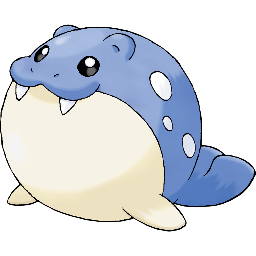

#369; Relicanth. (test) 
Type1 (actual): water 
Type1 (prediction): normal


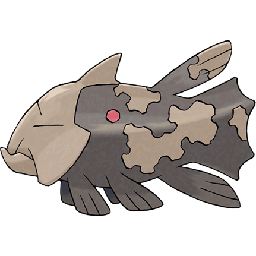

#393; Piplup. (test) 
Type1 (actual): water 
Type1 (prediction): psychic


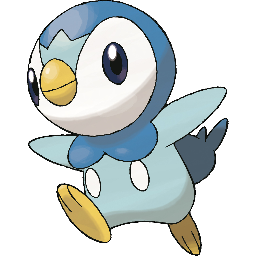

#430; Honchkrow. (test) 
Type1 (actual): dark 
Type1 (prediction): electric


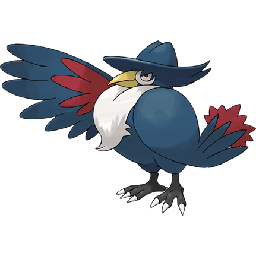

#448; Lucario. (test) 
Type1 (actual): fighting 
Type1 (prediction): psychic


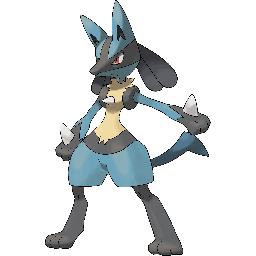

In [11]:
testing_mistakes = []

for n in range(1,722):
  if pokemodel.splitter(n) == "test":
    if not pokemodel.predict_from_number(n,0) == pokemon.type1[n-1]:
      pokemodel.predict_from_number(n,1)
      testing_mistakes.append(n)

So, of the 9 total testing mistakes we can identify a trend. Take a pokemon like Relicanth (#369). The model classifies Relicanth as a normal type. This makes alot of sense, Relicanth is a brownish pokemon, and most normal types are brown like. As an example here is Relicanth against the correctly classified Bidoof (#399)

#369; Relicanth. (test) 
Type1 (actual): water 
Type1 (prediction): normal


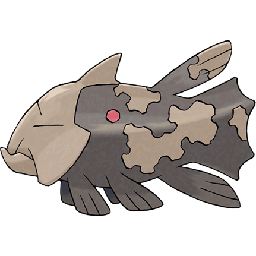

#399; Bidoof. (train) 
Type1 (actual): normal 
Type1 (prediction): normal


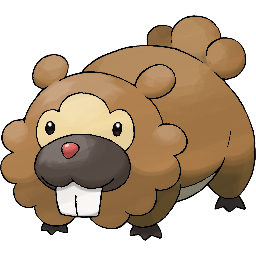

In [18]:
pokemodel.predict_from_number(369,1)
pokemodel.predict_from_number(399,1)

So it seems like a big part of the detector is a colour classifier. But shape also seems to be a component of the model. Lets look at the incorrectly classified pokemon #363 Spheal (classified as ghost) and the correctly classified ghost-type #92 (Ghastly)

#363; Spheal. (test) 
Type1 (actual): ice 
Type1 (prediction): ghost


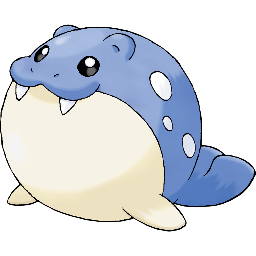

#92; Gastly. (train) 
Type1 (actual): ghost 
Type1 (prediction): ghost


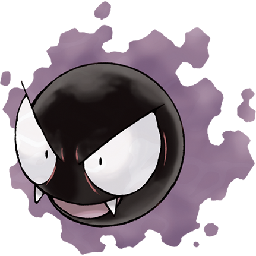

In [21]:
pokemodel.predict_from_number(363,1)
pokemodel.predict_from_number(92,1)

So the model also seems to care about shape. As it identifies both of these as ghost types. Lastly, let's see how the model does on pokemon created after the first 6th generations. We'll take #930 Aboliva, a grass type from the 9th generation. The model correctly classified this pokemon as a grass type.

Saving 930.png to 930.png
1/1 [==============================] - 0s 51ms/step
Type1 (prediction): grass


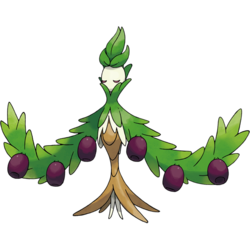

In [29]:
pokemodel.predict_from_images()

So, my hope was to create a rudamentary model that demonstrates my ability with python, OOP, data science and machine learning (specifically in computer vision and classification problems) and I think this model does that!

Obviously the choice of pokemon was a bit goofy, but it was mostly to demonstrate how powerful of a tool this is. It got nearly perfect on training data, and 5 times better than random on testing data with a very small data set.